
Se usa un dataset cargado en drive, por lo tanto se necesita acceder a drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


El dataset esta comprimido por lo tanto se descomprime mediante rarfile

In [ ]:
!pip install rarfile

In [ ]:

import os
import rarfile

Se busca el dataset en el drive y se extrae de la ruta en la que se encuentra

In [ ]:
rar_file_path = '/content/drive/MyDrive/Apple diseases.rar'

In [ ]:
extract_path = '/content/apple_diseases'

In [ ]:
os.makedirs(extract_path, exist_ok=True)

In [ ]:
with rarfile.RarFile(rar_file_path, 'r') as rf:
    rf.extractall(extract_path)

Se importa shutil que es el módulo para gestionar archivos y carpetas y train_test_split importa la función para dividir datos en conjuntos de entrenamiento y prueba.

In [ ]:

import shutil
from sklearn.model_selection import train_test_split

Se crea una carpeta en la ubicación, en caso de que esté enviara un mensaje diciendo que ya está

In [ ]:

def create_folder(folder_path, folder_name):
    try:
        new_folder_path = os.path.join(folder_path, folder_name)
        if not os.path.exists(new_folder_path):
            os.makedirs(new_folder_path)
            print(f"Folder '{folder_name}' created at '{folder_path}'.")
        else:
            print(f"Folder '{folder_name}' already exists at '{folder_path}'.")
    except Exception as e:
        print(f"Error: {e}")

Se verifica que la imagen sea valida

In [ ]:
def is_valid_image(image_path):
  return True

La función copia imágenes de una carpeta a otra, creando la carpeta destino si no existe. Solo copia imágenes de al menos 224x224 píxeles, ignorando las más pequeñas.

In [ ]:
def copy_files(src_folder, dest_folder):
    try:
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        for filename in os.listdir(src_folder):
            src_path = os.path.join(src_folder, filename)
            dest_path = os.path.join(dest_folder, filename)

            if is_valid_image(src_path):
                shutil.copy2(src_path, dest_path)
            else:
                print(f"Skipping file '{filename}' due to size less than 224 x 224 pixels.")

        print(f"All eligible files from '{src_folder}' successfully copied to '{dest_folder}'.")
    except Exception as e:
        print(f"Error: {e}")

La función divide imágenes en conjuntos de entrenamiento y prueba (80%-20% por defecto) y las copia a sus respectivas carpetas.

In [ ]:
def split_data(src_folder, train_folder, test_folder, test_size=0.2):
    all_files = [os.path.join(src_folder, f) for f in os.listdir(src_folder) if is_valid_image(os.path.join(src_folder, f))]
    train_files, test_files = train_test_split(all_files, test_size=test_size)

    for f in train_files:
        shutil.copy2(f, os.path.join(train_folder, os.path.basename(f)))

    for f in test_files:
        shutil.copy2(f, os.path.join(test_folder, os.path.basename(f)))

Se crea la carpeta data si no existe

In [ ]:
base_dir = "/content/data"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

La lista folders contiene los nombres de las categorías de enfermedades y hojas saludables de manzana, utilizadas para organizar imágenes en diferentes carpetas.

In [ ]:
folders = [
    'Apple___scab', 'Apple___black_rot', 'Apple___rust', 'Apple___healthy',
    'Apple___alternaria_leaf_spot', 'Apple___brown_spot', 'Apple___gray_spot'
]

Crea las carpetas de train y test dentro de data y dentro de ellas se encuentran las carpetas de cada enfermedad

In [ ]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for folder in folders:
    create_folder(train_dir, folder)
    create_folder(test_dir, folder)


Folder 'Apple___scab' already exists at '/content/data/train'.
Folder 'Apple___scab' already exists at '/content/data/test'.
Folder 'Apple___black_rot' already exists at '/content/data/train'.
Folder 'Apple___black_rot' already exists at '/content/data/test'.
Folder 'Apple___rust' already exists at '/content/data/train'.
Folder 'Apple___rust' already exists at '/content/data/test'.
Folder 'Apple___healthy' already exists at '/content/data/train'.
Folder 'Apple___healthy' already exists at '/content/data/test'.
Folder 'Apple___alternaria_leaf_spot' already exists at '/content/data/train'.
Folder 'Apple___alternaria_leaf_spot' already exists at '/content/data/test'.
Folder 'Apple___brown_spot' already exists at '/content/data/train'.
Folder 'Apple___brown_spot' already exists at '/content/data/test'.
Folder 'Apple___gray_spot' already exists at '/content/data/train'.
Folder 'Apple___gray_spot' already exists at '/content/data/test'.


El código divide las imágenes de cada categoría en entrenamiento y prueba, copiándolas a sus respectivas carpetas.

In [ ]:
dataset_path = os.path.join(extract_path, '/content/apple_diseases')

In [ ]:
for folder in folders:
    src_folder = os.path.join(dataset_path, folder)
    train_folder = os.path.join(train_dir, folder)
    test_folder = os.path.join(test_dir, folder)
    split_data(src_folder, train_folder, test_folder)

Se importan las librerias necesarias para la red convolucional

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
train_dir = "/content/data/train"
test_dir = "/content/data/test"

Se selecciona un batch de 64, procesando 64 imagenes por lote, se probó con diferentes numeros de epocas pero 20 fueron las que brindaron mejor resultado   y las imagenes son de 256x256 y 3 canales rgb

In [ ]:
batch_size = 64
epochs = 20
input_shape = (256, 256, 3)

Prepara las imágenes para el modelo, aplicando aumentaciones y normalización en el entrenamiento, mientras que en la prueba solo normaliza. Luego, los generadores cargan las imágenes organizadas por categorías.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 6277 images belonging to 7 classes.
Found 2357 images belonging to 7 classes.


Se importa el GlobalAvergaePooling2D que ayuda a entrenar el modelo mas rapido

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout


Este modelo CNN clasifica imágenes de hojas de manzana usando tres capas convolucionales con ReLU de 16,32 y 64 filtros para extraer características, MaxPooling2D para reducir dimensiones en este caso a la mitad, GlobalAveragePooling2D para aplanar los datos y dos capas densas una con 256 neuronas y la de salida que usa softmax para predecir la enfermedad.

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(216, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


El código compila el modelo utilizando el optimizador Adam para ajustar los pesos, la entropía cruzada categórica como función de pérdida para clasificación multiclase, y exactitud como métrica para evaluar el rendimiento del modelo durante el entrenamiento.

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Se entrena el modelo

In [ ]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/99 ━━━━━━━━━━━━━━━━━━━━ 17:36 13s/step - accuracy: 0.2347 - loss: 1.9115

KeyboardInterrupt: 

Muestra el val-loss y el accuracy del modelo

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

Se guarda el modelo para cargarlo en streamlit

In [ ]:
model.save('/content/drive/MyDrive/ciencia_de_datos2.h5')

In [ ]:
from tensorflow.keras.models import load_model

A partir de aca el codigo que se usa es para poner a prueba el modelo con imagenes al azar de la carpeta de prueba

In [ ]:
model = load_model('/content/drive/MyDrive/ciencia_de_datos2.h5')

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
def load_and_preprocess_image(img_path, target_size=(256, 256)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [ ]:
def get_random_image_from_test_dir(test_dir):
    categories = os.listdir(test_dir)
    category = random.choice(categories)
    category_path = os.path.join(test_dir, category)
    images = os.listdir(category_path)
    image_name = random.choice(images)
    image_path = os.path.join(category_path, image_name)
    return image_path, category

In [ ]:
img_path, true_category = get_random_image_from_test_dir(test_dir)

In [ ]:
img_array = load_and_preprocess_image(img_path)

In [ ]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


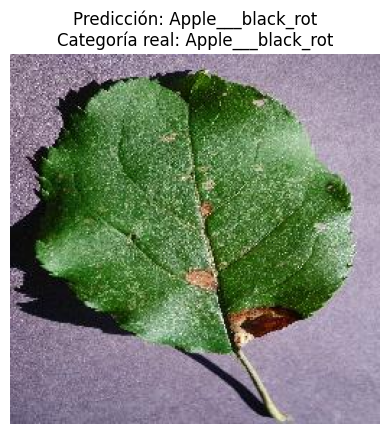

In [ ]:
img = tf.keras.preprocessing.image.load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicción: {predicted_label}\nCategoría real: {true_category}")
plt.show()

In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,089,993 (49.93 MB)

 Trainable params: 13,089,991 (49.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)